In [1]:
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import utide
import matplotlib.dates as mdates
from scipy import stats
import matplotlib.pyplot as plt # plotting tool

In [2]:
TG_loc_INCOIS = pd.read_csv('/Volumes/RB/WORK/RAW_TG_DATA/INCOIS_TG/Readme.txt',delimiter='\t\t',nrows=35)

/Volumes/RB/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [27]:
for x in range(0, 2): 
    Name=TG_loc_INCOIS['Station '].loc[x]
    Lat = TG_loc_INCOIS['Latitude'].loc[x]
    out = Name+".csv"
    print(out,Lat)
    

AdaniHazira.csv 21.1
AerialBay.csv 13.283


In [4]:
Lat1=TG_loc_INCOIS.loc[TG_loc_INCOIS['Station '] == "Paradeep"]#.loc[0,'Latitude']
Lat1['Latitude']

27    20.267
Name: Latitude, dtype: float64

In [10]:
#  read TG data from a location csv file

#    """combine all files with same TG ID
#    Parameters:
#    ============
#        ID: str
#            Location of TG to combine data
#    Returns:
#    ===========
#        combined_data: pandas Dataframe

def readData(fpath):
    data = pd.read_csv(fpath,header=None,names=['name','datetimes','rad','prs','enc'],parse_dates={'datetime':[1]},index_col='datetime',na_values=9999.99).drop_duplicates()
    return data

def readTG(ID):
    fp = glob.glob(f'/Volumes/RB/WORK/RAW_TG_DATA/INCOIS_TG/{ID}_*.csv',recursive = True)
    df = pd.concat([readData(f) for f in fp])
    return (ID,df.asfreq(freq='min'))

In [11]:
ID,TG   = readTG('Paradeep')
Lat=TG_loc_INCOIS.loc[TG_loc_INCOIS['Station '] == "Paradeep",'Latitude']
Sensor1 = TG.loc[:,'rad']
Sensor2 = TG.loc[:,'prs']
Sensor3 = TG.loc[:,'enc']

In [12]:
z_scores1 = stats.zscore(Sensor1,nan_policy='omit') ;
z_scores2 = stats.zscore(Sensor2,nan_policy='omit') ;
z_scores3 = stats.zscore(Sensor3,nan_policy='omit') ;
abs_z_scores1 = np.abs(z_scores1) ;
abs_z_scores2 = np.abs(z_scores2) ;
abs_z_scores3 = np.abs(z_scores3) ;
filtered_entries1 = (abs_z_scores1 < 3); Sensor1_s11 = Sensor1[filtered_entries1]
filtered_entries2 = (abs_z_scores2 < 3); Sensor2_s11 = Sensor2[filtered_entries2]
filtered_entries3 = (abs_z_scores3 < 3); Sensor3_s11 = Sensor3[filtered_entries3]

In [13]:
#Sensor1_s1.loc['2013-10-11 12':'2013-10-12 14'].plot(figsize=(15, 5))
#Sensor2_s1.loc['2013-10-11 12':'2013-10-13 14'].plot(figsize=(15, 5))
Sensor1_s1=Sensor1_s11.asfreq(freq='min') #.loc['2013-1-11 12':'2013-10-12 14'].plot(figsize=(15, 5))
Sensor2_s1=Sensor2_s11.asfreq(freq='min')
Sensor3_s1=Sensor3_s11.asfreq(freq='min')

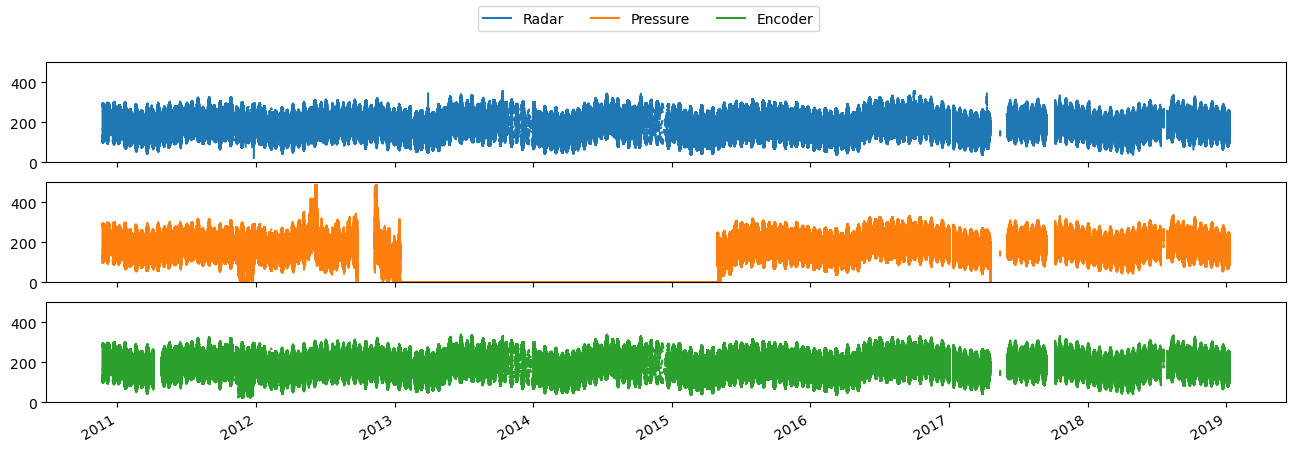

In [14]:
#Sensor1_s1.plot(figsize=(18,4))
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,figsize=(16,5), dpi=100)
ax0.plot(Sensor1_s1, label=u'Radar',    color='C0')
ax1.plot(Sensor2_s1, label=u'Pressure', color='C1')
ax2.plot(Sensor3_s1, label=u'Encoder',  color='C2')
ax2.set_ylim([0, 500])
ax2.xaxis_date()
fig.legend(ncol=3, loc='upper center')
fig.autofmt_xdate()

In [15]:
# create a function to analyse Tide using U-Tide
def Tide_analyse(Sensor,std,edt,lat):
    dat  = Sensor.loc[std:edt]
    time = mdates.date2num(dat.index.to_pydatetime())
    coef = utide.solve(time, dat.values,
                       lat=lat,
                       constit='auto',
                       method='ols',  # {'ols', 'robust'}, Solve with ordinary least squares, or with a robust algorithm.
                       conf_int='MC') # {'linear', 'MC', 'none'}, If not 'none' (string), calculate linearized confidence
                                      # intervals, or use a Monte-Carlo simulation.
    tide = utide.reconstruct(time, coef)
    return (dat,tide)

In [16]:
# Create a 1.4 year (17 month) data section
#fp  = Sensor1_s1.first_valid_index()
#lp  = Sensor1_s1.last_valid_index()
#rng = pd.date_range(fp, lp,freq="3 M") # put here 17

In [85]:
fp  = Sensor2_s1.first_valid_index()
lp  = Sensor2_s1.last_valid_index()
count = fp
start = fp
while (count < lp):
    count = start + pd.DateOffset(months=6) # put here 17 
#    print(start,count)
    per1=(len(Sensor1_s1[start:count].dropna())/len(Sensor1_s1[start:count]))*100
    per2=(len(Sensor2_s1[start:count].dropna())/len(Sensor2_s1[start:count]))*100
    per3=(len(Sensor3_s1[start:count].dropna())/len(Sensor3_s1[start:count]))*100
    print(start,count,per1,per2,per3)
#    if per3 >= 30 :
#        print(start,count,"good")
#    else : 
#        print(start,count,"bad")
    start = count + pd.DateOffset(minutes=1)

2010-11-23 07:29:00 2011-05-23 07:29:00 84.91795227918861 84.92255631308964 76.39243250294466
2011-05-23 07:30:00 2011-11-23 07:30:00 78.62855288136744 78.97426413698619 78.8176373126611
2011-11-23 07:31:00 2012-05-23 07:31:00 61.01319820971379 62.07851771017358 61.9835089151827
2012-05-23 07:32:00 2012-11-23 07:32:00 96.44060824045802 74.6732537996158 96.55609693502063
2012-11-23 07:33:00 2013-05-23 07:33:00 63.23563829174995 62.959779927179525 63.34920446130885
2013-05-23 07:34:00 2013-11-23 07:34:00 25.750204747113724 25.696989368246648 25.750959575182762
2013-11-23 07:35:00 2014-05-23 07:35:00 47.47526290951922 47.48754033325532 47.48984235020584
2014-05-23 07:36:00 2014-11-23 07:36:00 25.162193681334234 25.164458165541344 25.164458165541344
2014-11-23 07:37:00 2015-05-23 07:37:00 46.58975372255325 46.503811756400566 46.614308570025436
2015-05-23 07:38:00 2015-11-23 07:38:00 79.4615056555493 79.47207324851581 79.47207324851581
2015-11-23 07:39:00 2016-05-23 07:39:00 83.402459544949

<AxesSubplot:xlabel='datetime'>

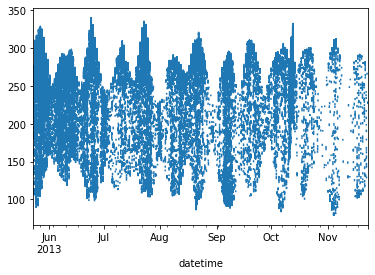

In [88]:
Sensor3_s1['2013-05-23 07:34:00':'2013-11-23 07:34:00'].plot()

In [89]:
# Create a 1.4 year (17 month) data section

fp  = Sensor1_s1.first_valid_index()
lp  = Sensor1_s1.last_valid_index()
count = fp
start = fp
appended_data = []
while (count < lp):   
    count = start + pd.DateOffset(months=1) # put here 17 
    print(start,count)
    
    per1=(len(Sensor1_s1[start:count].dropna())/len(Sensor1_s1[start:count]))*100
    per2=(len(Sensor2_s1[start:count].replace(0,np.nan).dropna())/len(Sensor2_s1[start:count].replace(0,np.nan)))*100
    per3=(len(Sensor3_s1[start:count].dropna())/len(Sensor3_s1[start:count]))*100
    
    if per1 >= 25 :
        RAD,tideR = Tide_analyse(Sensor1_s1,start,count,20.26)
        Rad = RAD - tideR.h
    else :
        Rad = (Sensor1_s1[start:count]*0).replace(0,np.nan)
        
    if per2 >= 25 :
        PRS,tideP = Tide_analyse(Sensor2_s1,start,count,20.26)
        Prs = PRS - tideP.h
    else :
        Prs = (Sensor2_s1[start:count]*0).replace(0,np.nan)
        
    if per3 >= 25 :
        ENC,tideE = Tide_analyse(Sensor3_s1,start,count,20.26)
        Enc = ENC - tideE.h
    else :
        Enc = (Sensor3_s1[start:count]*0).replace(0,np.nan)
    
    frames = [Rad,Prs,Enc]
    result = pd.concat(frames,axis=1)
    # saving the dataframe
    appended_data.append(result)
    #result.to_csv('result.csv', mode='a', header=False,na_rep=999.99)
    #break
    start = count + pd.DateOffset(minutes=1)
    
appended_data = pd.concat(appended_data)

2010-11-23 07:29:00 2011-05-23 07:29:00
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
2011-05-23 07:30:00 2011-11-23 07:30:00
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
2011-11-23 07:31:00 2012-05-23 07:31:00
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
2012-05-23 07:32:00 2012-11-23 07:32:00
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
2012-11-23 07:33:00 2013-05-23 07:33:00
solve: matrix prep ... solution ... done.
pr

<AxesSubplot:xlabel='datetime'>

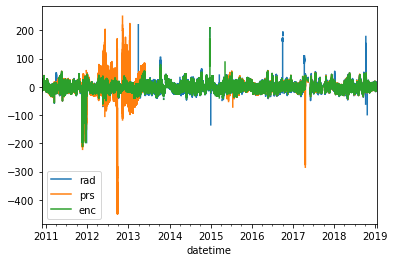

In [90]:
#plot tide 
#def plot_tide(dat,tide,lev):
#    t = tide.t_mpl
#    fig, (ax0) = plt.subplots(figsize=(18,4))
#    ax0.plot(t, dat - tide.h, label=u'Residual', color='C2')
#    ax0.set_ylim([lev*-1, lev])
#    ax0.xaxis_date()
#    fig.legend(loc='upper center')
#    fig.autofmt_xdate()
#result.plot(figsize=(18,5))
appended_data.plot()

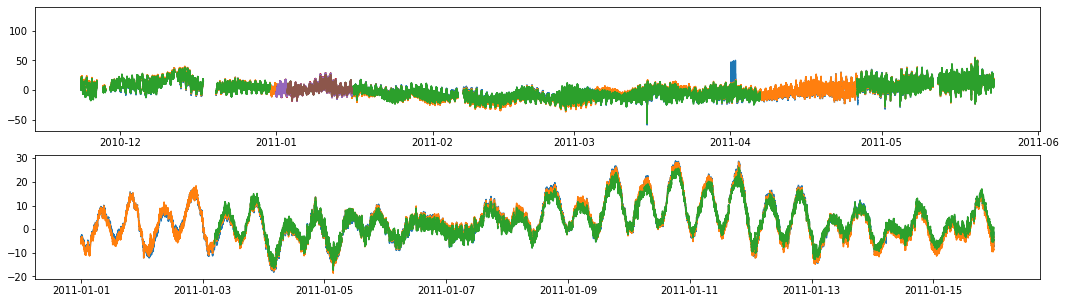

In [40]:
fig, ax = plt.subplots(2,figsize=(18,5))
ax[0].plot(result)
ax[0].plot(result.loc["01-jan-2011":"15-Jan-2011"])
ax[1].plot(result.loc["01-Jan-2011":"15-Jan-2011"])#,color='C4')
#fig.autofmt_xdate()

In [208]:
# saving the dataframe
#Rad.to_csv('file1.csv',na_rep=999.99)
#Rad.to_csv('file1.csv', mode='a', header=False,na_rep=999.99)